# 📊 Pre‑RAG Data‑Profiling

**exploratory analysis** of the two knowledge‑base datasets that will feed the retrieval‑augmented chatbot:

* `faqs_cleaned.csv`
* `products_occupation.json`

The aim is to surface data‑quality issues and useful statistics **before** we wire these corpora into a vector store.

# Nexora RAG Customer Service Chatbot – Demo & Implementation Guide
**Author:** Sujan Adhikari

This interactive notebook walks through building a Retrieval‑Augmented Generation (RAG) customer‑service chatbot for **Nexora Pty Ltd** using **LangChain**, **Ollama Embeddings + gemma3**, and **ChromaDB**.  It covers:
1. Data loading & preprocessing  
2. Vector‑store creation  
3. Simple intent recognition & entity extraction  
4. RAG pipeline assembly  
5. Lightweight streamlit web‑chat demo 

---

In [11]:
import pandas as pd, json, itertools, matplotlib.pyplot as plt
import csv
plt.rcParams['figure.figsize'] = (8,4)

## 2  FAQ dataset overview

In [12]:
FAQS_FILE = 'data/faqs.csv'
FAQS_CLEANED_FILE = 'data/faqs_cleaned.csv'
# CSV Cleaning (as provided, robust for unquoted commas in question field)

with open(FAQS_FILE, "r", encoding="utf-8") as infile, \
    open(FAQS_CLEANED_FILE, "w", newline="", encoding="utf-8") as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)

    try:
        header = next(reader)
        writer.writerow(header)

        for row in reader:
            if not row: continue # Skip empty rows
            if len(row) > 3: # Question field likely contains unquoted commas
                question_parts = row[:-2]
                question = ",".join(question_parts).strip('" ') # Join and strip quotes/spaces
                answer = row[-2].strip('" ')
                category = row[-1].strip('" ')
                writer.writerow([question, answer, category])
            elif len(row) == 3:
                writer.writerow([col.strip('" ') for col in row])
            else:
                print(f"Skipping malformed FAQ row: {row}") # Log malformed rows
    except StopIteration:
        print(f"Warning: {FAQS_FILE} might be empty or just has a header.")
        # Create an empty cleaned file with header if original was empty/header-only
        if 'header' not in locals() or not header: header = ['question', 'answer', 'category']
        writer.writerow(header)

df_faq = pd.read_csv(FAQS_CLEANED_FILE)
print('FAQ rows, columns:', df_faq.shape)

FAQ rows, columns: (130, 3)


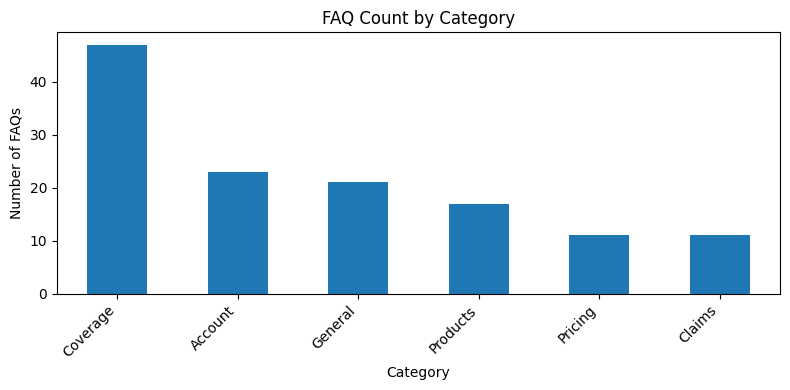

In [13]:
# Category distribution
faq_cat = df_faq['category'].value_counts()
plt.figure()
faq_cat.plot(kind="bar")
plt.title("FAQ Count by Category")
plt.xlabel("Category")
plt.ylabel("Number of FAQs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [14]:
# Duplicate questions
dupes = df_faq[df_faq.duplicated('question', keep=False)]
print('Number of duplicated question texts:', dupes['question'].nunique())
display(dupes[['question','category']].head())

Number of duplicated question texts: 8


,question,category
14,How do I get a quote?,General
25,How do I renew my policy?,Account
26,Can I cancel my policy?,Account
28,What information do I need to provide for a cl...,Claims
29,How long does the claims process take?,Claims


Duplicates need consolidation; otherwise the retriever might surface two conflicting answers to the same query.

In [15]:
# Length stats
df_faq['question_length'] = df_faq['question'].str.len()
df_faq['answer_length']   = df_faq['answer'].str.len()
display(df_faq[['question_length','answer_length']].describe().round(2))

,question_length,answer_length
count,130.00,130.00
mean,41.47,144.00
std,11.03,45.78
min,21.00,62.00
25%,34.00,108.25
50%,40.00,132.50
75%,49.00,173.00
max,72.00,262.00


Lengths confirm that each Q‑A pair fits comfortably into a single embedding, so no chunking is required.

## 3  Product & Occupation dataset overview

In [16]:
with open('data/products_occupation.json', 'r', encoding='utf-8') as f:
    prod_occ = json.load(f)

df_products = pd.json_normalize(prod_occ['products'])
df_occ      = pd.json_normalize(prod_occ['occupation_data'])
print('Products rows, columns:', df_products.shape)
print('Occupation rows, columns:', df_occ.shape)

print('Products columns:', df_products.columns.tolist())
print('Occupation columns:', df_occ.columns.tolist())

Products rows, columns: (6, 15)
Occupation rows, columns: (91, 5)
Products columns: ['product_id', 'name', 'description', 'target_industries', 'coverage_options', 'key_features', 'exclusions', 'unique_selling_points', 'required_documents', 'premium_range.min', 'premium_range.max', 'premium_range.currency', 'excess_range.min', 'excess_range.max', 'excess_range.currency']
Occupation columns: ['industry', 'occupation', 'risk_level', 'recommended_products', 'claim_likelihood']


In [17]:
# Compute character counts for each product and each occupation
product_lengths = [
    len(json.dumps(prod, ensure_ascii=False))
    for prod in prod_occ['products']
]
occupation_lengths = [
    len(json.dumps(occ, ensure_ascii=False))
    for occ in prod_occ['occupation_data']
]

# 3. Build a DataFrame with separate columns
df_desc = pd.DataFrame({
    'product_char_count': pd.Series(product_lengths),
    'occupation_char_count': pd.Series(occupation_lengths)
})

# 4. Get descriptive statistics
stats = df_desc.describe()
print(stats)

       product_char_count  occupation_char_count
count            6.000000              91.000000
mean          1058.500000             194.164835
std             69.661324              22.258713
min            975.000000             142.000000
25%           1004.000000             178.000000
50%           1062.000000             195.000000
75%           1099.000000             207.000000
max           1156.000000             252.000000


In [18]:
# Risk and claim statistics
corr = df_occ['risk_level'].corr(df_occ['claim_likelihood']).round(3)
print('Correlation risk ↔ claim:', corr)

Correlation risk ↔ claim: 0.065


* `risk_level` is a 1–5 ordinal scale; `claim_likelihood` is continuous – keep both fields because they are almost uncorrelated.

In [19]:
# Product recommendation frequency across occupations
from collections import Counter
prod_counts = Counter(itertools.chain.from_iterable(df_occ['recommended_products']))
pd.Series(prod_counts).sort_values(ascending=False).to_frame('count')

,count
Business Insurance,91
Professional Indemnity,41
Management Liability,39
Public Liability,38
Tax Audit Insurance,28
Cyber Insurance,24


This frequency table tells you which covers are recommended most often and therefore which ones the chatbot should prioritise when asked generic questions.

In [21]:
from pathlib import Path
CHAT_CONVERSATIONS_FILE = Path('data/chat_conversations.json')
chat_conversation_docs = [] # Not directly adding to KB for RAG now, but for analysis
if CHAT_CONVERSATIONS_FILE.exists():
    with open(CHAT_CONVERSATIONS_FILE, 'r', encoding='utf-8') as f:
        try:
            chat_data = json.load(f)
            print(f"Loaded {len(chat_data)} chat conversations from {CHAT_CONVERSATIONS_FILE}.")
            # Example: Extracting simple Q&A patterns for potential KB augmentation or intent examples
            # This is a conceptual step; full processing would require more sophisticated logic.
            potential_new_qas = []
            for conv in chat_data:
                messages = conv.get('messages', [])
                for i in range(len(messages) - 1):
                    if messages[i]['role'] == 'customer' and messages[i+1]['role'] == 'agent':
                        # Simple heuristic: if customer asks and agent answers immediately
                        q = messages[i]['text']
                        a = messages[i+1]['text']
                        # Further filtering could be applied (e.g., length, keywords)
                        if len(q) > 10 and len(a) > 10 and "?" in q: # Basic filter
                             potential_new_qas.append({"question": q, "answer": a, "source_conversation_id": conv.get("id")})
            
            print(f"Identified {len(potential_new_qas)} potential Q&A pairs from chat logs for review.")
            if potential_new_qas:
                print("Example potential Q&A:", potential_new_qas[0])
            
            # We are NOT adding these to `documents` for now to keep the KB focused on curated content (products, FAQs).
            # These would be candidates for manual review and addition to FAQs, or for fine-tuning datasets.

        except json.JSONDecodeError as e:
            print(f"Error decoding {CHAT_CONVERSATIONS_FILE}: {e}")
            chat_data = []
        except Exception as e:
            print(f"An error occurred while processing {CHAT_CONVERSATIONS_FILE}: {e}")
            chat_data = []
else:
    print(f"{CHAT_CONVERSATIONS_FILE} not found. Skipping chat conversation analysis.")
    chat_data = []

Loaded 100 chat conversations from data\chat_conversations.json.
Identified 143 potential Q&A pairs from chat logs for review.
Example potential Q&A: {'question': 'What insurance do I need as a IT Consultant?', 'answer': 'As a IT Consultant in the IT Services industry, you should consider Tax Audit Insurance, Business Insurance, Management Liability insurance. The exact coverage needed depends on your specific business operations and risks.', 'source_conversation_id': 'conv_658aa0c1'}
